# Practical Week 9: Neural Nets and Deep Learning Answers

In this practical you will implement simple convolutional neural nets (CNNs) to classify images. First, we will consider the well-known MNIST Handwriting Recognition example to familiarise ourselves with the Keras Tensorflow library that we will use. Then, you will implement a simple CNN that is capable of identifying what type of object is shown in an image.

This work is not assessed, and you do not need to submit it. Please ask questions if you are facing difficulties with any of the content in this practical.



For this practical, we may want to use a GPU. Training deep neural nets on a CPU will take a long time.
Google Colab provides us with some limited access to GPU-enabled kernels. There are some restrictions on uptime (~3 hours) and maximum GPU usage per day/week.

To switch to a GPU-enabled kernel, go the *Runtime* menu at the top of the page, select *Change Runtime Type*, and select *GPU* under *Hardware accelerator*.

Once you have done that, the kernel will restart.
Verify that the GPU is indeed available by executing this cell:

In [66]:
!nvidia-smi

Fri Oct  1 11:41:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    70W / 149W |   4365MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If a GPU is available, we can see the GPU type (model name), GPU memory, and some further information about its state. Google Colab currently provides Tesla K80 and T4 GPUs. These are not the latest hardware, but will suffice for our purpose. After all, they are free to use!

If you can't use Google Colab and don't have a GPU, you can still run the code but it will take significantly longer. What may take 2 minutes on a GPU can take more than 30 minutes on a fast CPU!

Next, load the relevant libraries.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report


## Activity 1: Load MNIST

The MNIST dataset consists of 60,000 images of handwritten digits for training, and another 10,000 images for testing. Here are a few examples of the images:

![MNIST Example Images](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Our task is to create a neural net that can infer from the images which digit (0,...,9) is shown on each image.

First, let's load the MNIST dataset and examine the data.

In [68]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [69]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

We learn that the training set consists of 60,000 square images of size 28x28, and that the test set contains 10,000 images of the same size. Each image is associated with the target label. 

Let's look at the first training image:

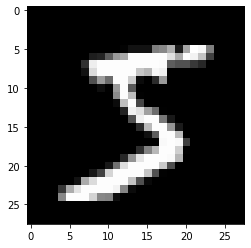

In [70]:
plt.imshow(X_train[0], cmap='gray');

It appears to represent the digit '5'.

Let's verify that the correct label associated with the first training image is indeed '5':


In [71]:
y_train[0]

5

Next, let's examine the distribution of the labels. You can use [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) to determine the frequency of each label in the training vector (use `return_counts=True`).

Is the data set balanced?

In [72]:
_, frequencies = np.unique(y_train, return_counts=True)
frequencies/sum(frequencies)

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

We see that each class appears about equally frequent, roughly 9-11% each, in the dataset. Thus, the dataset is balanced.

Let's see how the image is represented in the data set:

In [73]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

We have a 2-dimensional array of size 28x28, where the first dimension represents the rows and the second dimension represents the columns. 

We see that each entry in the image is a single value. That is, the image is a monochrome image (greyscale). Each value in the array reprsents a pixel intensity. In the image, maximum intensity (255) is shown as white colour, while zero is black.

Let's see what the pixel value is at row 10 column 9. (The top left of the image is row 0 column 0.)

In [74]:
X_train[0][10,9]

14

Next, let's look at the value ranges in this image and in all images. Use [`min`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.min.html) and [`max`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html).

In [75]:
X_train[0].min(), X_train[0].max()

(0, 255)

In [76]:
X_train.min(), X_train.max()

(0, 255)

We see that the pixel values in the first training image range in 0,...,255. The same range is obained for the full data set. That is, there are no other images that have values outside this range.

## Activity 2: Transform the Data

To feed a 2-dimensional image into a neural net, we must first transform it into a 1-dimensional array. In this case, we must *flatten* the 28x28 array into an array of length 784. We can use [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html) do perform this task for all images in the entire training set at once. Thus, the 60000x28x28 array becomes a 60000x784 array. We transform the test set in a similar way.

In [77]:
X_train = X_train.reshape(60000,784)
X_test = X_test.reshape(10000,784)


In [78]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Next, we need to **normalize** the data. Neuronal nets work best when the input values are all small numbers in the range 0,...,1 or -1,...,1. Since the pixel intensities in the MNIST dataset range over 0,...,255, we must normalise them to 0,...,1. Do this by dividing each value in the training and test set by 255.

In [79]:
X_train = X_train / 255
X_test = X_test / 255

Verify that all values are in the range 0,...,1.

In [80]:
X_train.min(), X_train.max()

(0.0, 1.0)

Next we look at the target labels associated with the images. Since there are 10 labels (digits '0',...,'9'), our neuronal net will have ten output units, one for each class. To train such a network, we must change the way the target label is represented. 

Instead of using a single variable that can take on ten different values, we will use ten different target variables which each can take on either zero or one. If a variable has value `1` then this means that the target label is the class associated with that variable. Since each image is associated with a unique class, at most one of these variables can have value 1, all other variables must be zero for each image.

This encoding is called `one-hot encoding`, since at most one of the variables is non-zero for each image. Suppose that we introduce ten target variables, one for each digit. In this encoding, the first image (class 5) would be encoded as `[0,0,0,0,0,1,0,0,0,0]`. The variable representing class 5 is set to one while the other variables are set to zero.

Next, we will change `y_train` and `y_test` to use one hot encoding. Function [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) does this for us.

In [81]:
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

We verify that the result has the correct shape and content:

In [82]:
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [83]:
Y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

We obtain the correct 60000x10 and 10000x10 shape. The first few rows of the 2-dimensional array look correct, too. They each have exactly one 1 in the position of the target class, and are zero elsewhere.

## Activity 3: Train a Fully Connected Feed Forward Network

Now that we have prepared the data, we can train a fully connected feed forward neural net. 

We will create a simple network that consists of the following layers:

* Hidden layer 1: 512 units, ReLU activation, followed by Dropout with probability 0.2
* Hidden layer 2: 512 units, ReLU activation, Dropout (0.2)
* Output layer: 10 units (one per class), softmax activation

For each layer, we specify the number of units, the activation function. For units in the hidden layers we also adopt Dropout regularisation to avoid overfitting. 

Each unit in the layers is connected to each unit in the layer below (or the input if there is no lower layer). This architecture is called a *fully connected* (*"dense"*) network.

The input to this network will be a vector of length 784 (one input per pixel in the input image).

Let's create this network architecture using Keras: 

we create a [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) net architecture where we can add the layers one after another. We begin by adding the [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) connections between input and the first hidden layer. Here, we must specify the number of hidden units and the size of the input that the network will receive. Next, we add the [`relu`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) activation function and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) for the first hidden layer. We repeat this for the second layer, omitting the input size specification (as Keras infers this from the units in the layer below). Finally, we add the output layer units.

In [84]:
def get_ff_mnist_model():
  model = Sequential()
  # Hidden layer 1
  # (784,) means a vector of length 784
  model.add(Dense(512, input_shape=(784,)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  # Hidden layer 2
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  # Output layer
  model.add(Dense(10))
  model.add(Activation('softmax'))
  return model
model = get_ff_mnist_model()

Let's print and verify the structure of the model.

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_22 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_23 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

We see that the elements we added are stacked on top of each other (the input enters at the top and the output is produced by the bottomost layer). For each layer, we wee the output shape that the layer produces, and the number of learnable weights ("Param #") that the model contains. We see that the net has 669,706 parameters that it must learn from the data.

The `None` value in the first dimension on each layer represents the sample index in our data set. Since the model can be trained with any number of samples (we haven't told it how many there are), the value of this dimension is `None` (that means "variable").

Next, we must compile the model. Keras is built on top of Tensorflow, which is able to transform the model into code that can run directly on GPUs. This transformation is called model compilation. 

When compiling a model, we must specify a loss function, an optimiser, and one or more metrics. 

* The loss function we will use here is called *categorical cross-entropy*, and is a loss function that is well-suited to comparing two probability distributions. This is a good loss function for our classification problem, since we wish to minimise the differences between the distribution of `y_train` and the distribution of labels predicted by the model. Ideally, these two would be identical and the loss would be zero.

* The optimiser helps to minimise the loss by gradient descent. It determines how to update the weights in the model to reduce the loss. This process is guided by a hyperparameter called *learning rate*. A larger learning rate may help the model learn faster, but it may not be able to learn the optimal weights if the learning rate is too large. We will use the popular *Adam* optimiser here, using its default learning rate.

* The metrics measure how well the model is doing on the classification task. Here, we will use *Accuracy* as the metric to monitor. 


Let's compile our model.

In [86]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we are ready to train the model.

Recall that neural nets are trained iteratively in *epochs*. In each epoch, the entire training data is fed into the model. Since even modern GPUs don't have sufficient memory to take all training data at once, we feed the data in batches. We must decide how many samples per batch size we shall use, and for how many epochs we may want to train our model.

Here, we will use 128 samples per batch and train for 5 epochs. 

To be able to select a good model that does not suffer from overfitting, we hold out 20% of the 60,000 training samples. The optimiser will compute loss ("val_loss") and accuracy ("val_accuracy") on this held-out data set so that we can detect when the model begins to overfit. Recall that an increasing validation loss and decreasing validation accuracy are signs of overfitting.

Keras provides a [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) function to train the model. It is similar to the fit function we have been using in scikit-learn in the past practicals. The fitting function returns a *history* object that we can interrogate for information about each epoch. 

In [87]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
375/375 [==============================] - 3s 6ms/step - loss: 0.2807 - accuracy: 0.9162 - val_loss: 0.1250 - val_accuracy: 0.9625
Epoch 2/5
375/375 [==============================] - 2s 5ms/step - loss: 0.1131 - accuracy: 0.9651 - val_loss: 0.0997 - val_accuracy: 0.9703
Epoch 3/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0762 - accuracy: 0.9762 - val_loss: 0.0796 - val_accuracy: 0.9758
Epoch 4/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.0803 - val_accuracy: 0.9753
Epoch 5/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0475 - accuracy: 0.9849 - val_loss: 0.0738 - val_accuracy: 0.9790


Training this model on a CPU takes about 7 second per epoch, for at total of ~34 seconds. On a GPU, we can achieve the same in about 2 seconds per epoch.

We wee that the optimiser has reduced the loss from ~0.28 to ~0.047 while accuracy has increased from ~0.92 to ~0.98 on the trainig set as training progressed. At the same time, accuracy on the validation set increased from 0.96 to 0.975 after epoch 3, then started to decline slightly. This tells us that the model obtained at the end of epoch 3 is perhaps the one we shall select. (Your results may differ slightly.)

Let's plot the learning curve to confirm:

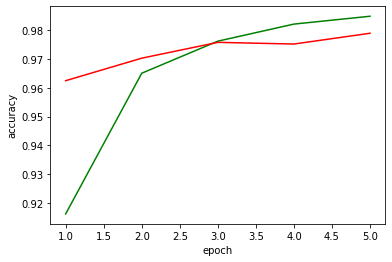

In [88]:
training_df = pd.DataFrame.from_dict(history.history).assign(epoch=np.array(history.epoch)+1)
sns.lineplot(data=training_df, x='epoch', y='accuracy', color='green');
sns.lineplot(data=training_df, x='epoch', y='val_accuracy', color='red');

We confirm that the model at epoch 3 yields best validation accuracy.

Now we can re-create the best model by stopping training after 3 epochs. We re-create the model, compile, and train. However this time we don't need the validation split as we have already chosen the best model.

In [89]:
model = get_ff_mnist_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=128, epochs=3, verbose=1)

Epoch 1/3
469/469 [==============================] - 2s 4ms/step - loss: 0.2529 - accuracy: 0.9233
Epoch 2/3
469/469 [==============================] - 2s 4ms/step - loss: 0.1015 - accuracy: 0.9683
Epoch 3/3
469/469 [==============================] - 2s 4ms/step - loss: 0.0714 - accuracy: 0.9775


## Activity 4: Evaluate the model

Now that we have trained our model, let's test how well it generalises to unseen data.

In [90]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0713 - accuracy: 0.9771


[0.07125527411699295, 0.9771000146865845]

We see that the accuracy on the test set closely matches the accuracy on the validation set during training. This builds our confidence that the model has learned well.

To analyse its performance in mode detail, let's obtain predictions for the each of the test set images:

In [91]:
Y_pred_proba = model.predict(X_test)

In [92]:
Y_pred_proba.shape

(10000, 10)

In [93]:
Y_pred_proba[:10].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.84, 0.15, 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],
      dtype=float32)

For each image, we obtain 10 values, one for each class. The largest value denotes the class that the model predicts. If there is a single largest value then the model is "sure" of its prediction (but it may be sure yet be wrong!); otherwise if there are multiple values that are close to being largest then the model does not yield a clear unique prediction. After rounding to two decimal places, we see that for many images there is a single class predicted (a single 1 in each row). For some images, multiple non-zero values exist, but one dominates the others. This means that there is a good margin between the prediction of the most likely class and the next less-likely class. Although the classifier predicts a single most likely class for the samples we have inspected, this does not tell us if that prediction is actually correct. We need to compare this to the ground truth in the test set.

Let's find the predicted class (the index where the predicted probability is largest) in each row, and compute a classification report.

In [94]:
y_pred = np.argmax(Y_pred_proba, axis=1)

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.96      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.98      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



We observe that all metrics are close to one. Our classifier works well. :-)

# Activity 5: Train a CNN

We will repeat the above process with a Convolutional neural network architecture.

We begin by preparing the data in the same way as before, except that
* we do not flatten the images into a 1-dimensional array, and
* we add an additional dimension at the end (for channel).

We keep its two dimensions since the CNN will apply convolution operations to the 2-dimensional structure, and we add the additional dimension since the CNN architecture assumes that there is a channel dimension present, even if there is only once channel in a monochrome image.


In [96]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [97]:
# add an additional dimension to represent the single-channel
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train / 255
X_test = X_test / 255

We'll verify shape and contents of the first image:

In [98]:
X_train.shape

(60000, 28, 28, 1)

In [99]:
X_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

We see that the additional dimension (1 at the end of the shape vector) has been added, and that each value in the image array is now a singleton array instead of a plain floating point number.

We can use one hot encoding for the target labels in the training and the testing set as before.

In [100]:
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

In [101]:
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

Next, we create a CNN.

We'll use a simple architecture with 4 layers of convolutions, followed by 2 fully connected layers. Each convolution block begins with convolution filters of size 3x3. The number of filters varies in different layers; the first two layers use 32 [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) filters whereas the subsequente two layers use 64 filters. After the convolution, [`BatchNormalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) is applied. Batch normalization is a technique to rescale the activations to improve training performance. After normalization, the [`relu Activation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) is applied, followed by 2x2 [`MaxPooling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). This process repeats 4 times. At the end, we obtain 64 4x4 feature maps as the output of the last MaxPooling operation. These 64 matrices are then flattened into a 1-dimensional vector of length 1024. The remaining layers add a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) network on top of that vector. [`BatchNormalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) is used to improve the training, and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) is applied to combat overfitting. 


In [102]:

def get_mnist_cnn_model():
  model = Sequential()

  # Convolution Layer 1: 32 feature maps
  model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu', name='layer1'))

  # Convolution Layer 2: 32 feature maps
  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), name='layer2'))

  # Convolution Layer 3: 64 feature maps
  model.add(Conv2D(64,(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu', name='layer3'))

  # Convolution Layer 4: 64 feature maps
  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), name='layer4'))
  model.add(Flatten())

  # Fully Connected Layer 5
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  # Fully Connected Layer 6                       
  model.add(Dropout(0.2))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model
model = get_mnist_cnn_model()

Inspect the model structure.

In [103]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_20 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
layer1 (Activation)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_28 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 12, 12, 32)       

We can see that the layers progressively reduce the size of the image (from 28x28 down to 4x4) while doubling the number of channels (feature maps) in each layer. Eventually, the 64 feature maps of size 4x4 are flattened into a 1-dimensional vector of length 1024, which is then fed into two layers of fully connected layers that compute the classification output.

Let's compile and train the model as before. It will take ~ 1 minute when using a GPU.

In [104]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
375/375 [==============================] - 10s 24ms/step - loss: 0.0941 - accuracy: 0.9713 - val_loss: 0.6843 - val_accuracy: 0.7382
Epoch 2/5
375/375 [==============================] - 8s 22ms/step - loss: 0.0307 - accuracy: 0.9906 - val_loss: 0.0435 - val_accuracy: 0.9872
Epoch 3/5
375/375 [==============================] - 8s 22ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0345 - val_accuracy: 0.9898
Epoch 4/5
375/375 [==============================] - 8s 22ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.0521 - val_accuracy: 0.9848
Epoch 5/5
375/375 [==============================] - 8s 22ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0358 - val_accuracy: 0.9890


Plot the accuracy on the training set and the validation set, and determine the optimal number of epochs.

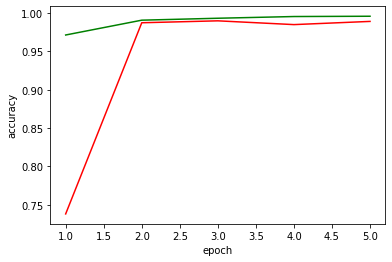

In [105]:
training_df = pd.DataFrame.from_dict(history.history).assign(epoch=np.array(history.epoch)+1)
sns.lineplot(data=training_df, x='epoch', y='accuracy', color='green')
sns.lineplot(data=training_df, x='epoch', y='val_accuracy', color='red');

We conclude that the validation result has stabilised after 2 (or 3) epochs. We now re-train the model on the full training set, stopping after 2 epochs.

In [106]:
model = get_mnist_cnn_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=128, epochs=2, verbose=1)


Epoch 1/2
469/469 [==============================] - 10s 19ms/step - loss: 0.0820 - accuracy: 0.9746
Epoch 2/2
469/469 [==============================] - 9s 18ms/step - loss: 0.0291 - accuracy: 0.9910


After ~22 seconds the model has completed training (when using a GPU).

## Activity 6: Evaluate the CNN Model

Let's evalute the model on the test set. Use the same procedure as for the fully connected network we trained earlier.

In [107]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0367 - accuracy: 0.9884


[0.03666616976261139, 0.9883999824523926]

In [108]:
Y_pred_proba = model.predict(X_test)
y_pred = np.argmax(Y_pred_proba, axis=1)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       1.00      0.96      0.98       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.95      1.00      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



We find that all metrics are very close to 1. The model works even better than the fully connected network we trained earlier!

However, it is not perfect. Let's see where the CNN errs. Let's see on which images the model produces results that differ from the ground truth in the test set.

In [109]:
# images it gets wrong
wrong_idx = np.nonzero(y_pred != y_test)[0]
len(wrong_idx)

116

We find that there are 116 images where predictions are wrong. (Your numbers may differ.) Let's visualise some of them.

Image 115 predicted as 9 but is actually 4.


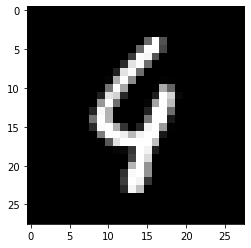

Image 139 predicted as 9 but is actually 4.


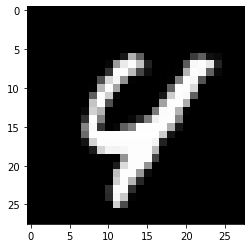

Image 445 predicted as 0 but is actually 6.


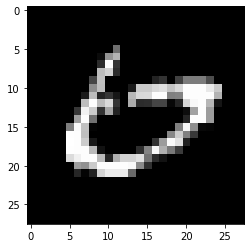

Image 447 predicted as 9 but is actually 4.


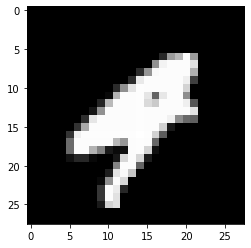

Image 449 predicted as 5 but is actually 3.


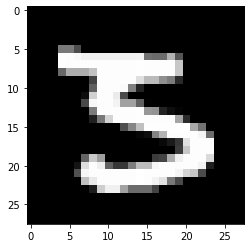

In [110]:
def show_image(idx):
  wrong_img_data = X_test[idx].reshape(28,28)
  print(f'Image {idx} predicted as {y_pred[idx]} but is actually {y_test[idx]}.')
  plt.imshow(wrong_img_data, cmap='gray')
for idx in wrong_idx[:5]:
  show_image(idx)
  plt.show()

Some of them are actually quite difficult to decipher.

Finally, we can peek inside the CNN and visualise how the network sees an image. Let's pick the first training image (a '5') and visualise the feature maps that the model generates at the output of each of the 4 convolution blocks in the model. (The corresponding layers are labelled 'layer1'...'layer4' in the model.)

In [111]:
from tensorflow.keras.models import Model

In [112]:
def visualise_features(model, layers, image):
  outputs = [model.get_layer(layer).output for layer in layers]
  vis_model = Model(inputs=model.inputs, outputs=outputs)
  image_data = np.expand_dims(image, axis=0)
  feature_maps = vis_model.predict(image_data)
  for fmap in feature_maps:
    channels = fmap.shape[-1]
    square = int(np.ceil(np.sqrt(channels)))
    for ix in range(channels):
      # specify subplot and turn of axis
      ax = plt.subplot(square, square, ix+1)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(fmap[:, :, ix], cmap='gray')

Layer layer1:


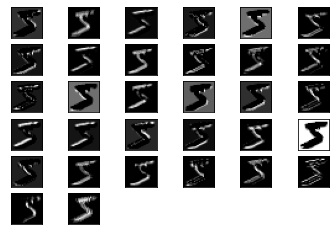

Layer layer2:


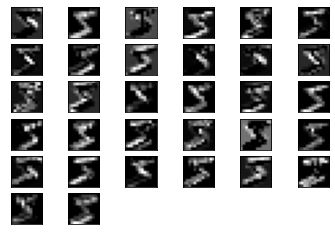

Layer layer3:


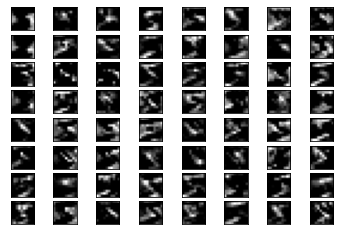

Layer layer4:


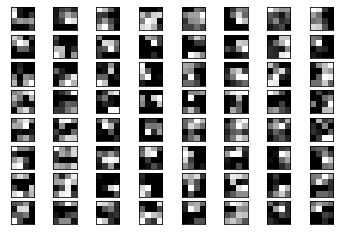

In [113]:
for layer in ['layer1','layer2','layer3','layer4']:
  print(f'Layer {layer}:')
  visualise_features(model, [layer], X_train[0] )
  plt.show()

## Activity 8: Train a CNN for Image Classification

Now that we have successfully built a CNN for handwritten digits, let's expand our work to image classification. You will create a CNN classifier for images across a wide range of different objects based on the CIFAR10 data set.

You will follow the same process as before: understand and prepare the data, define and train a model, and evaluate the model on the test set. 

Let's begin by loading the CIFAR10 dataset. The dataset consists of 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [114]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [115]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [116]:
y_train.shape, y_test.shape

((50000, 1), (10000, 1))

In [117]:
# The CIFAR labels happen to be arrays. Reshape the arrays to obtain 1-dimensional vectors.
y_train = y_train.reshape((-1,))
y_test = y_test.reshape((-1,))

We see that there are 60,000 images in total. Each image is 32x32 in size and has three channels (RGB).

As for MNIST, we must normalize the images to the range [0,..,1] and one-hot encode the target class labels.

In [118]:
X_train = X_train / 255
X_test = X_test / 255
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

Let's plot a few images to see what is in this data set.

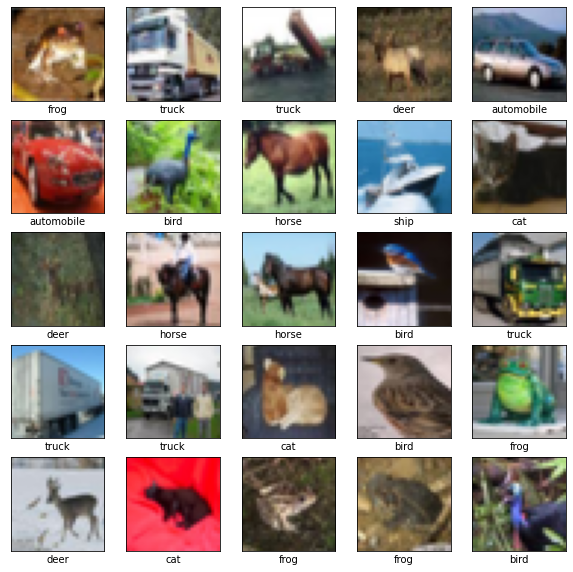

In [119]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i]])

Although the images are a little blurry, we can make out what is on each of them reasonably easily.

Let's see if we can adapt the CNN we used earlier to this new data set.

We will use the same layers, but change the input dimensions to 32x32x3 to match the CIFAR10 images.


In [132]:
def get_cifar10_cnn_model():
  model = Sequential()

  # Convolution Layer 1: 32 feature maps
  model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu', name='layer1'))

  # Convolution Layer 2: 32 feature maps
  model.add(Conv2D(32, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), name='layer2'))

  # Convolution Layer 3: 64 feature maps
  model.add(Conv2D(64,(3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu', name='layer3'))

  # Convolution Layer 4: 64 feature maps
  model.add(Conv2D(64, (3, 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), name='layer4'))
  model.add(Flatten())

  # Fully Connected Layer 5
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  # Fully Connected Layer 6                       
  model.add(Dropout(0.2))
  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

model = get_cifar10_cnn_model()

Summarise the model to see its structure:

In [133]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
layer1 (Activation)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_44 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 14, 14, 32)      

Then, compile and train the model.

We follow the same steps as for MNIST but train for 10 epochs and use a validation split of 10%. This will take ~3 minutes on a GPU.

In [134]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 16s 11ms/step - loss: 1.2431 - accuracy: 0.5651 - val_loss: 1.0409 - val_accuracy: 0.6364
Epoch 2/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.8360 - accuracy: 0.7058 - val_loss: 0.9442 - val_accuracy: 0.6698
Epoch 3/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6957 - accuracy: 0.7572 - val_loss: 0.9136 - val_accuracy: 0.6832
Epoch 4/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5894 - accuracy: 0.7934 - val_loss: 0.7502 - val_accuracy: 0.7424
Epoch 5/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.4980 - accuracy: 0.8253 - val_loss: 1.0501 - val_accuracy: 0.6618
Epoch 6/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.4220 - accuracy: 0.8517 - val_loss: 0.6844 - val_accuracy: 0.7734
Epoch 7/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.3437 - accuracy: 0.8796 - val_loss: 0.8145 -

Plot the learning curve determine the number of epochs that yield the model that performs best on the validation split.

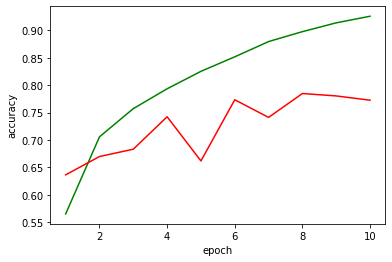

In [135]:
training_df = pd.DataFrame.from_dict(history.history).assign(epoch=np.array(history.epoch)+1)
sns.lineplot(data=training_df, x='epoch', y='accuracy', color='green')
sns.lineplot(data=training_df, x='epoch', y='val_accuracy', color='red');

We wee that the validation results climb until the end of epoch 6, and then decline and fluctuate. Although the model at epoch 10 has slightly higher validation accuracy, the gap between the training and the validation split has become large (which you may recall that this is a sign that the model has overfitted). Hence, we will select the model at 6 epochs. (Your results may differ.)

Let's train the model on the full training set for 6 epochs. This may take ~2 minutes on a GPU.

In [136]:
model = get_cifar10_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=6)


Epoch 1/6
1563/1563 [==============================] - 17s 10ms/step - loss: 1.2175 - accuracy: 0.5720
Epoch 2/6
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8152 - accuracy: 0.7147
Epoch 3/6
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6706 - accuracy: 0.7659
Epoch 4/6
1563/1563 [==============================] - 15s 10ms/step - loss: 0.5641 - accuracy: 0.8039
Epoch 5/6
1563/1563 [==============================] - 15s 10ms/step - loss: 0.4774 - accuracy: 0.8336
Epoch 6/6
1563/1563 [==============================] - 15s 10ms/step - loss: 0.4018 - accuracy: 0.8581


Now, test how well the model performs on the test set. Construct a classification report to assess the model's results for each class.

In [137]:
model.evaluate(X_test, Y_test)


313/313 [==============================] - 2s 6ms/step - loss: 0.7159 - accuracy: 0.7696


[0.7159004211425781, 0.769599974155426]

In [138]:
Y_pred_proba = model.predict(X_test)
y_pred = np.argmax(Y_pred_proba, axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    airplane       0.80      0.78      0.79      1000
  automobile       0.96      0.80      0.87      1000
        bird       0.73      0.66      0.69      1000
         cat       0.63      0.59      0.61      1000
        deer       0.60      0.87      0.71      1000
         dog       0.86      0.49      0.62      1000
        frog       0.72      0.91      0.80      1000
       horse       0.87      0.82      0.85      1000
        ship       0.82      0.89      0.85      1000
       truck       0.86      0.88      0.87      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



Looking at the F1 scores, we learn that the model performs reasonably well for classes automobile, frog, horse, ship, and truck. It performed worst overall for cat and dog. 

Construct a confusion matrix to see how the model errs. Use the function below to plot the matrix, since plugging the Keras classifier into the scikit-learn function plot_confusion_matrix() will not work.

In [127]:
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
  sns.heatmap(cm_df, annot=True, fmt='d'); # rows are true labels, columns are predictions

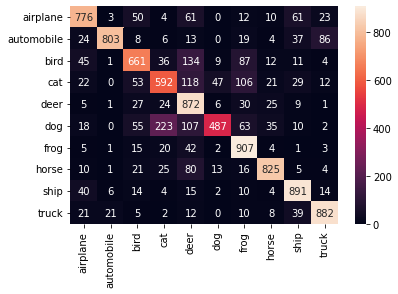

In [139]:
plot_cm(y_test, y_pred, class_names)

We see that cats are often mistaken as deer or frog, and dogs are often mistaken as cats.

Let's look at some of the images that the model gets wrong.

2304  images classified incorrectly
Image 4 predicted as deer but is actually frog.


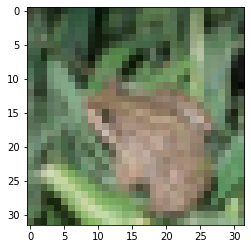

Image 9 predicted as ship but is actually automobile.


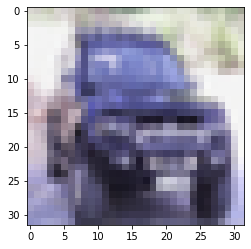

Image 12 predicted as deer but is actually dog.


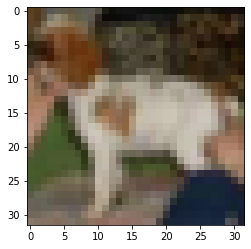

Image 22 predicted as airplane but is actually deer.


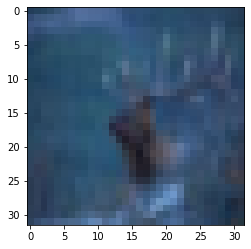

Image 24 predicted as deer but is actually dog.


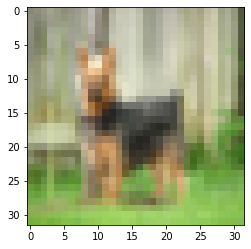

In [140]:
wrong_idx = np.nonzero(y_pred != y_test)[0]
print(len(wrong_idx),' images classified incorrectly')

def show_image(idx):
  print(f'Image {idx} predicted as {class_names[y_pred[idx]]} but is actually {class_names[y_test[idx]]}.')
  plt.imshow(X_test[idx], cmap='gray')
for idx in wrong_idx[:5]:
  show_image(idx)
  plt.show()

We can also look at some of the images that the model predicted correctly.

7696  images classified correctly
Image 0 correctly predicted as cat.


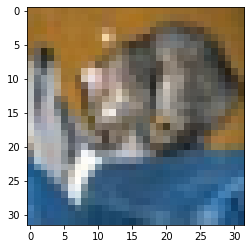

Image 1 correctly predicted as ship.


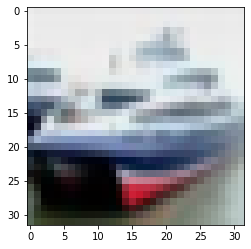

Image 2 correctly predicted as ship.


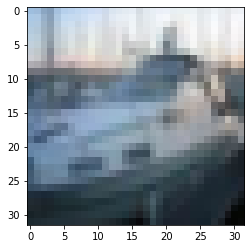

Image 3 correctly predicted as airplane.


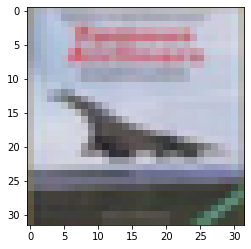

Image 5 correctly predicted as frog.


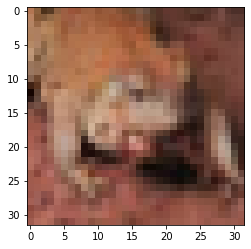

In [141]:
correct_idx = np.nonzero(y_pred == y_test)[0]
print(len(correct_idx),' images classified correctly')

def show_image(idx):
  print(f'Image {idx} correctly predicted as {class_names[y_pred[idx]]}.')
  plt.imshow(X_test[idx], cmap='gray')
for idx in correct_idx[:5]:
  show_image(idx)
  plt.show()

This concludes our investigation into CNNs for CIFAR10. The model we have designed here served us to learn how to construct, train, and analyse a model. The model is however still far from the best possible model that can be constructed. It is possible to design improved models that exhibit >96% accuracy on CIFAR10, and ~99.8% on MNIST. You can see the [list of high scores](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). To achieve this, more advanced models and data augmentation techniques must be used. If you are interested, [read about further ways to improve CNN models for image classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/). 

This concludes the practical. You should now be able to define a given CNN architecture in Keras and train and evaluate the model.